# Model Selection -- Shrinkage Methods
---
 - Ridge Regression
 - Lasso Regression
 - ElasticNet Regression

In [1]:
import io
import time
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## 0 Data

In [2]:
url = "https://raw.githubusercontent.com/katkatrina-K/Machine-Learning-Study/main/Data/Boston.csv"
s = requests.get(url).content
Boston = pd.read_csv(io.StringIO(s.decode('utf-8')))
Boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


 - crim:
per capita crime rate by town.

 - zn:
proportion of residential land zoned for lots over 25,000 sq.ft.

 - indus:
proportion of non-retail business acres per town.

 - chas:
Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

 - nox:
nitrogen oxides concentration (parts per 10 million).

 - rm:
average number of rooms per dwelling.

 - age:
proportion of owner-occupied units built prior to 1940.

 - dis:
weighted mean of distances to five Boston employment centres.

 - rad:
index of accessibility to radial highways.

 - tax:
full-value property-tax rate per $10,000.

 - ptratio:
pupil-teacher ratio by town.

 - lstat:
lower status of the population (percent).

 - medv:
median value of owner-occupied homes in $1000s.

#### Data Inspection

In [3]:
Boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  lstat    506 non-null    float64
 12  medv     506 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


In [4]:
Boston.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,37.970000,50.000000


It looks like there are no missing values, so we go straight to the next step of processing.

#### Preprocessing

In [5]:
seed = 45

In [6]:
# Split data into 80/20 in out of sample
Boston_train, Boston_test = train_test_split(Boston, test_size = .2, random_state = seed)
print('Train Sets: ', Boston_train.shape)
print('Test Sets: ', Boston_test.shape)

Train Sets:  (404, 13)
Test Sets:  (102, 13)


In [7]:
# Split X and y
X_train = Boston_train.drop('crim', axis = 1)
y_train = Boston_train.crim
X_test = Boston_test.drop('crim', axis = 1)
y_test = Boston_test.crim

In [8]:
# Preprocessing
cat_features = ['chas']
num_features = X_train.columns.difference(['chas'])

cat_tf = Pipeline(steps = [('scaler', StandardScaler(with_mean = False))])
num_tf = Pipeline(steps = [('scaler', StandardScaler())])
col_tf = ColumnTransformer(transformers = [('num', num_tf, num_features), ('cat', cat_tf, cat_features)])

## 1 Ridge Regression

#### Model

In [9]:
mod_ridge = Ridge(alpha = 0.01, max_iter = 10000, random_state = seed)
pipe_ridge = Pipeline(steps = [('col_tf', col_tf), ('model', mod_ridge)])

#### Tunning Grid

In [10]:
# Tunning Parameter: alpha
alpha_ridge = np.logspace(start = -2, stop = 2, base = 10, num = 100)
param_ridge = {'model__alpha': alpha_ridge}

# Cross-Validation
n_folds = 10
search_ridge = GridSearchCV(pipe_ridge, param_ridge, cv = n_folds, scoring = 'neg_mean_squared_error')
tic = time.time()
search_ridge.fit(X_train, y_train)
toc = time.time()
print('Execution time:', toc-tic, 'seconds')

# CV Results
cv_ridge = pd.DataFrame({'alpha': alpha_ridge,
                         'RMSE': -search_ridge.cv_results_['mean_test_score']})
cv_ridge

Execution time: 6.059514284133911 seconds


,alpha,RMSE
0,0.010000,50.505689
1,0.010975,50.505655
2,0.012045,50.505618
3,0.013219,50.505577
4,0.014508,50.505533
...,...,...
95,68.926121,51.472266
96,75.646333,51.581509
97,83.021757,51.697664
98,91.116276,51.820990


<Figure size 800x500 with 0 Axes>

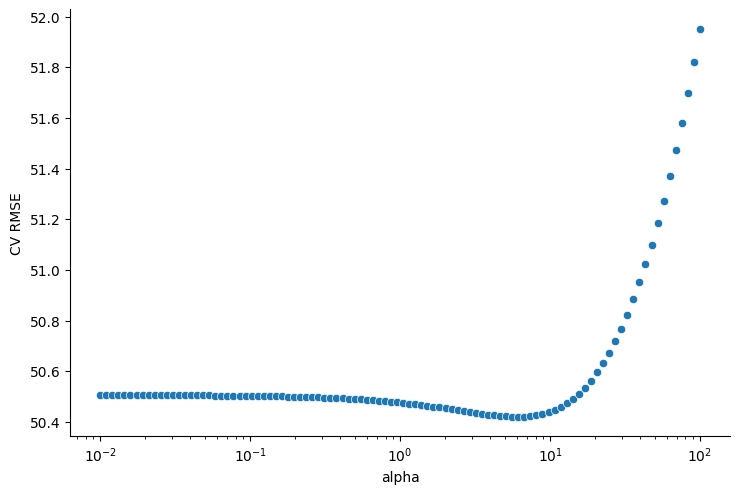

In [11]:
# CV Results Visualization
plt.figure(figsize = (8,5))
sns.relplot(data = cv_ridge, x = 'alpha', y = 'RMSE', height = 5, aspect = 1.5).set(
    xlabel = 'alpha', ylabel = 'CV RMSE', xscale = 'log')
plt.show()

In [12]:
search_ridge.best_estimator_

Pipeline(steps=[('col_tf',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'dis', 'indus', 'lstat', 'medv', 'nox', 'ptratio', 'rad', 'rm',
       'tax', 'zn'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['chas'])])),
                ('model',
                 Ridge(alpha=6.135907273413176, max_iter=10000,
                       random_state=45))])

#### Evaluation

In [13]:
y_pred_ridge = search_ridge.best_estimator_.predict(X_test)
test_RMSE_ridge = mean_squared_error(y_test, y_pred_ridge, squared = False)
cv_RMSE_ridge = np.sqrt(-search_ridge.best_score_)
print(f'CV RMSE: {cv_RMSE_ridge:.4f}')
print(f'test RMSE: {test_RMSE_ridge:.4f}')

CV RMSE: 7.1007
test RMSE: 4.3209


## 2 Lasso Regression

#### Model

In [14]:
mod_lasso = Lasso(alpha = 0.01, max_iter = 10000, random_state = seed)
pipe_lasso = Pipeline(steps = [('col_tf', col_tf), ('model', mod_lasso)])

#### Tunning Grid

In [15]:
# Tunning Parameter: alpha
alpha_lasso = np.logspace(start = -2, stop = 1, base = 10, num = 100)
param_lasso = {'model__alpha': alpha_lasso}

# Cross-Validation
n_folds = 10
search_lasso = GridSearchCV(pipe_lasso, param_lasso, cv = n_folds, scoring = 'neg_mean_squared_error')
tic = time.time()
search_lasso.fit(X_train, y_train)
toc = time.time()
print('Execution time:', toc-tic, 'seconds')

# CV Results
cv_lasso = pd.DataFrame({'alpha': alpha_lasso,
                         'RMSE': -search_lasso.cv_results_['mean_test_score']})
cv_lasso

Execution time: 6.142177104949951 seconds


,alpha,RMSE
0,0.010000,50.470699
1,0.010723,50.468722
2,0.011498,50.466701
3,0.012328,50.464633
4,0.013219,50.462560
...,...,...
95,7.564633,82.770574
96,8.111308,82.770574
97,8.697490,82.770574
98,9.326033,82.770574


<Figure size 800x500 with 0 Axes>

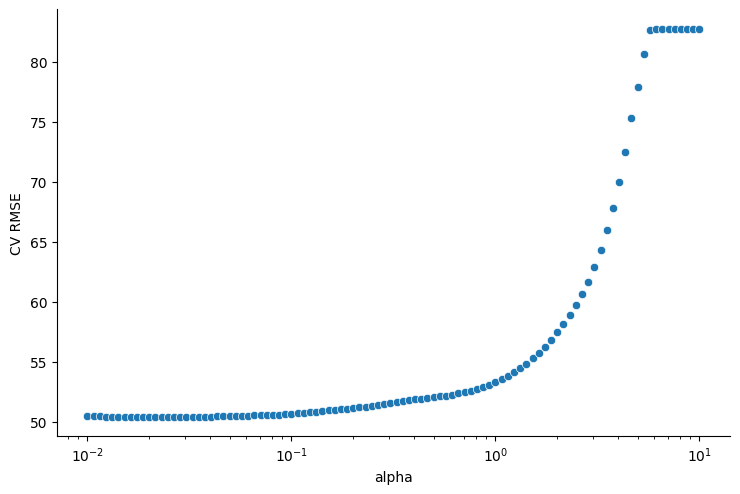

In [16]:
# CV Results Visualization
plt.figure(figsize = (8,5))
sns.relplot(data = cv_lasso, x = 'alpha', y = 'RMSE', height = 5, aspect = 1.5).set(
    xlabel = 'alpha', ylabel = 'CV RMSE', xscale = 'log')
plt.show()

In [17]:
search_lasso.best_estimator_

Pipeline(steps=[('col_tf',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'dis', 'indus', 'lstat', 'medv', 'nox', 'ptratio', 'rad', 'rm',
       'tax', 'zn'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['chas'])])),
                ('model',
                 Lasso(alpha=0.026560877829466867, max_iter=10000,
                       random_state=45))])

#### Evaluation

In [18]:
y_pred_lasso = search_lasso.best_estimator_.predict(X_test)
test_RMSE_lasso = mean_squared_error(y_test, y_pred_lasso, squared = False)
cv_RMSE_lasso = np.sqrt(-search_lasso.best_score_)
print(f'CV RMSE: {cv_RMSE_lasso:.4f}')
print(f'test RMSE: {test_RMSE_lasso:.4f}')

CV RMSE: 7.1026
test RMSE: 4.3630


## ElasticNet

#### Model

In [19]:
mod_ent = ElasticNet(alpha = 0.01, l1_ratio = 0.01, max_iter = 10000, random_state = seed)
pipe_ent = Pipeline(steps = [('col_tf', col_tf), ('model', mod_ent)])

#### Tunning Grid

In [20]:
# Tunning Parameter: alpha, l1_ratio
alpha_ent = np.logspace(start = -4, stop = -1, num = 30)
l1_ent = np.linspace(start = 0.0, stop = 1.0, num = 10)
param_ent = {'model__alpha': alpha_ent,
             'model__l1_ratio': l1_ent}

# Cross-Validation
n_folds = 10
search_ent = GridSearchCV(pipe_ent, param_ent, cv = n_folds, scoring = 'neg_mean_squared_error')
tic = time.time()
search_ent.fit(X_train, y_train)
toc = time.time()
print('Execution time:', toc-tic, 'seconds')

# CV Results
cv_ent = pd.DataFrame({'alpha': search_ent.cv_results_['param_model__alpha'],
                       'l1_ratio': search_ent.cv_results_['param_model__l1_ratio'],
                       'RMSE': -search_ent.cv_results_['mean_test_score']})
cv_ent

Execution time: 42.14669632911682 seconds


,alpha,l1_ratio,RMSE
0,0.0001,0.0,50.504778
1,0.0001,0.111111,50.504872
2,0.0001,0.222222,50.504966
3,0.0001,0.333333,50.505060
4,0.0001,0.444444,50.505153
...,...,...,...
295,0.1,0.555556,50.654698
296,0.1,0.666667,50.616565
297,0.1,0.777778,50.629447
298,0.1,0.888889,50.653763


<Figure size 800x500 with 0 Axes>

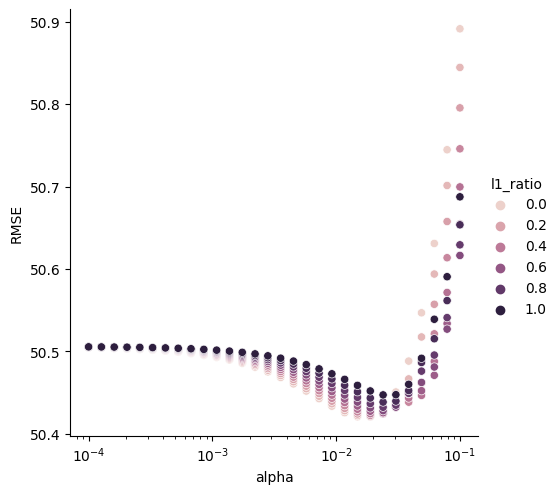

In [21]:
# CV Results Visualization
plt.figure(figsize = (8,5))
sns.relplot(data = cv_ent, x = 'alpha', y = 'RMSE', hue = 'l1_ratio').set(
    xlabel = 'alpha', ylabel = 'RMSE', xscale = 'log' )
plt.show()

In [22]:
search_ent.best_estimator_

Pipeline(steps=[('col_tf',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'dis', 'indus', 'lstat', 'medv', 'nox', 'ptratio', 'rad', 'rm',
       'tax', 'zn'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  ['chas'])])),
                ('model',
                 ElasticNet(alpha=0.014873521072935119, l1_ratio=0.0,
                            max_iter=10000, random_state=45))])

#### Evaluation

In [23]:
y_pred_ent = search_ent.best_estimator_.predict(X_test)
test_RMSE_ent = mean_squared_error(y_test, y_pred_ent, squared = False)
cv_RMSE_ent = np.sqrt(-search_ent.best_score_)
print(f'CV RMSE: {cv_RMSE_ent:.4f}')
print(f'test RMSE: {test_RMSE_ent:.4f}')

CV RMSE: 7.1008
test RMSE: 4.3224


## Comparison

#### Summary

In [24]:
methods = {'Ridge': [cv_RMSE_ridge, test_RMSE_ridge],
           'Lasso': [cv_RMSE_lasso, test_RMSE_lasso],
           'ElasticNet': [cv_RMSE_ent, test_RMSE_ent]}
summary = pd.DataFrame.from_dict(methods, orient='index', columns=['cv RMSE', 'test RMSE'])
summary

,cv RMSE,test RMSE
Ridge,7.100731,4.320886
Lasso,7.102585,4.362953
ElasticNet,7.100759,4.322393


#### Feature Importance

In [25]:
feature_names = X_test.columns

Text(0.5, 1.0, 'Coefficients of features from ElasticNet')

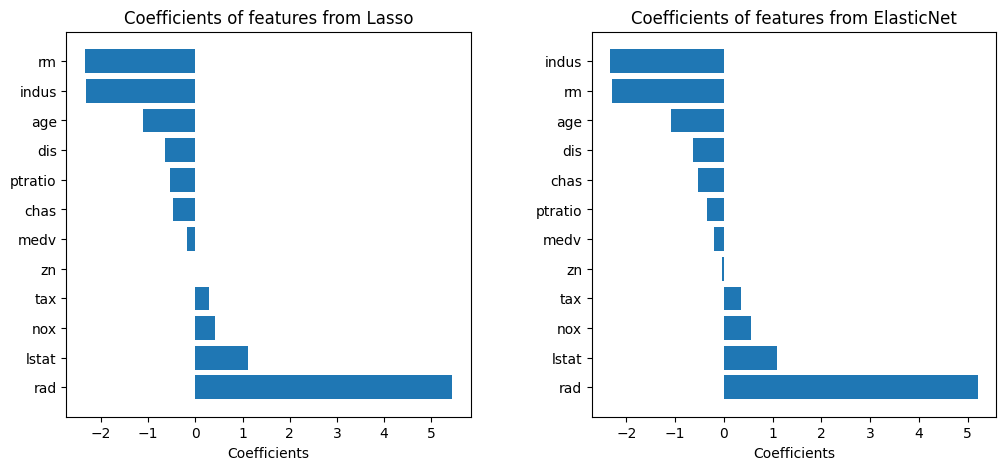

In [26]:
fig, axs = plt.subplots(1,2, figsize = (12,5))
plt.subplots_adjust(wspace = 0.3)
coefficients_lasso = search_lasso.best_estimator_.named_steps['model'].coef_
coefs_lasso = pd.DataFrame({'feature': feature_names, 
                            'coef': coefficients_lasso}).sort_values('coef', ascending = False)
axs[0].barh(coefs_lasso['feature'], coefs_lasso['coef'])
axs[0].set_xlabel('Coefficients')
axs[0].set_title('Coefficients of features from Lasso')

coefficients_ent = search_ent.best_estimator_.named_steps['model'].coef_
coefs_ent = pd.DataFrame({'feature': feature_names, 
                          'coef': coefficients_ent}).sort_values('coef', ascending = False)
axs[1].barh(coefs_ent['feature'], coefs_ent['coef'])
axs[1].set_xlabel('Coefficients')
axs[1].set_title('Coefficients of features from ElasticNet')